# Assignment 3

The goal of this assignment is to practice designing, debugging and training of convolutional neural networks using PyTorch for classifying 200 bird species in Caltech-UCSD Birds 200-2011 image dataset. We will also learn to use the transfer learning approach to exploit pertained deep networks and prevent overfitting in the absence of large training datasets.


As always, we first import PyTorch libraries.

In [1]:
import torch
from torch import nn
torch.manual_seed(123)


Again, as in previous tutorials, next we need to mount Google Drive in Colab. This will allow us to access dataset files stored on our Google Drive.
Run the next cell to start the Google Drive mount process.
Click on the link that the running the Colab cell prints.
You’ll be prompted to sign into your Google account and a message about the permissions that this action will grant to Colab.
After accepting, you’ll be shown a one-time code. Copy and paste the code back into the Colab cell and hit enter. Now the Colab notebook has mounted your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part A - Convolutional Neural Network Classifier

In the first part, you will implement the following convolutional neural network baseline for the 200 category classification task.


### 1. 
Implement VGG block in PyTorch and use the block to implement VGG-11, VGG-13 and VGG-16 networks corresponding to configuration A, B and D in the table below. Note that every convolutional layer is followed by a ReLU activation.
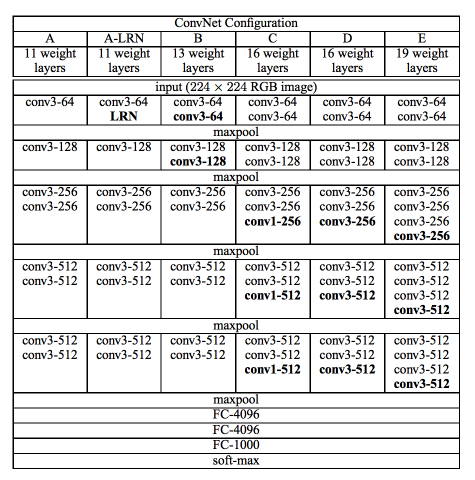

In [3]:
# using the vgg_block function from chapter 9 notebook:
# always using  3x3 kernels and maxpool 2x2 with stride 2

from typing import Tuple

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):   # if more convolution after another loop over number og layers
        layers.append(
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=3, padding=1))
        layers.append(nn.ReLU()) # after each convulution, one relu activation
        in_channels = out_channels
    # max-ppoling after convolution block with 1 or more convolutions
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) 
    return nn.Sequential(*layers)


def vgg(conv_setup: Tuple):
    conv_blks = []
    in_channels = 3 # important to change this to 3, we have rgb-images in our dataset, so 3 channels
    # The convolutional part
    for (num_convs, out_channels) in conv_setup:
        conv_blks.append(vgg_block(num_convs, 
                                   in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), # 7x7 is the shape of the last feature map of the last conv-layer
        nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 1000), nn.ReLU(), nn.Dropout(0.4),
        nn.Linear(1000, 200))  # putting a additional linear layer with 200 outputs at the end,
        # to get a prob for each class, softmax will be included in the crossentropy-loss,
        # I am not specifically adding a softmax-layer for that.

# input to get convolutions of A (VGG-11)
vgg_11_setup = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

# to get our first vgg, we just need to call the vgg function with the correct
# convolution parameters:

vgg_11 = vgg(vgg_11_setup).to('cuda')

vgg_11

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [ ]:
# check if we recieve right output shapes:

X = torch.rand(size=(1, 3, 224, 224)).to('cuda')
for layer in vgg_11:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 1000])
ReLU output shape:	 torch.Size([1, 1000])
Dropout output shape:	 torch.Size([1, 1000])
Linear output shape:	 torch.Size([1, 200])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Looking good!

Next: B or VGG-13:

I was a bit confused what "conv1-256" in the third conv-block of C means, is it
a convolutional layer with kernel size 1?

this wouldn't be a problem to implement.
I would just make the kernel_size a argument for the vgg_block function
(with the default being 3) and input a 3-element tuple.

But i decided against it, because every source that I found for vgg-13
didnt have 1-kernel conv-layers, for example [here](https://www.amirhf.com/post/tf-vgg13-mnist/).


In [ ]:

vgg_13_setup = ((2, 64), (2, 128), (2, 256), (2, 512), (2, 512))

vgg_13 = vgg(vgg_13_setup).to('cuda')


Last one, D or VGG-16:

In [ ]:
vgg_16_setup = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))

vgg_16 = vgg(vgg_16_setup).to('cuda')

### 2. 
Download the Caltech-UCSD Birds 200-2011 from this [link](https://drive.google.com/file/d/1M2td6Iz6Ty3GvUfAsYQWG4vODVjJ5HSo/view?usp=sharing). The dataset is already split into training and testing datasets. Upload the dataset to your Google Drive. Split the training dataset into training and validation dataset containing 90% and 10% of the examples respectively.



### 3. 
Implement data loaders in PyTorch for the training, validation and test dataset. The images in Caltech-UCSD Birds are of different dimensions. Therefore, they should be resized to a fixed standard resolution (for example 224x224). You should use the `RandomResizedCrop` transform provided in `torchvision.transforms` for the training dataset. For the validation and test dataset you are not allowed to use random transformations. Therefore, you should use a combination of `Resize` and `CenterCrop` transformations for the test and validation datasets. As always, do not forget to normalise your datasets.

In [ ]:
# I am doing step 2 and 3 in one go.
# First I am loading in the full train dataset and split it into train and val.
# Then I am transforming each dataset with the right transformation.
# For normalizing I use the Image-net values, which is sensible in a case
# like this where we have similar pictures.
# Lastly we get dataloaders for the datasets.

from torchvision import datasets, models, transforms
import os
from torch.utils.data import Dataset, DataLoader

data_dir = '/content/drive/MyDrive/DS405B/cub/'


# loading in full train as tensor:
train_dataset_full = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          transforms.ToTensor())

# splitting into train (90%) and val (10%):
# Task A.2
from torch.utils.data import random_split

val_size = int(0.1*len(train_dataset_full))
train_size = len(train_dataset_full)-val_size

birds_train, birds_val = random_split(train_dataset_full, [train_size, val_size])

print(len(birds_train),len(birds_val))


5395 599


In [ ]:
# Transformations for each dataset:
transforms_train = transforms.Compose([
                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
                    transforms.RandomResizedCrop(224)])
                                         
transforms_val = transforms.Compose([
                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
                    transforms.Resize(224),
                    transforms.CenterCrop(224)])

transforms_test = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
                    transforms.Resize(224),
                    transforms.CenterCrop(224)])

# to apply these transform, I am using again the Dataset subclass ive used in assignment 2:

class Dataset_transform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:     # in this step we apply the transform that are given in the call
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [ ]:
# now apply the transformations:

birds_train = Dataset_transform(birds_train, transform=transforms_train)

birds_val = Dataset_transform(birds_val, transform=transforms_val)

birds_test_raw = datasets.ImageFolder(os.path.join(data_dir, 'test'))
birds_test = Dataset_transform(birds_test_raw, transform=transforms_test)

# Dataloaders:


loader_train = torch.utils.data.DataLoader(birds_train, batch_size=8,shuffle=True)
loader_val = torch.utils.data.DataLoader(birds_val, batch_size=8,shuffle=False)
loader_test = torch.utils.data.DataLoader(birds_test, batch_size=8,shuffle=False)


### 4.
Implement classification loss, optimiser and the training loop. Make sure to plot the training and validation loss over the training iterations. Select a batch size equals 8. Feel free to modify it based on how much memory you have in Google Colab.

In [ ]:
# crossentropy loss

loss_birds = nn.CrossEntropyLoss()


In [ ]:
import matplotlib.pyplot as plt


def training_loop(model, epochs, loss_function, train_loader, val_loader, learnrate = 0.003, plot=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=learnrate)
    training_loss_values = [] # empty list we store the loss-value in after each epoch
    val_loss_values = []
    for epoch in range(1,epochs):
      model.train()
      for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        out = model(images)
        loss = loss_function(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      loss = loss_function(out, labels)
      training_loss_values.append(loss) # add to list which will be plotted
      model.eval() # now in evaluation mode, important for dropout
      with torch.no_grad():  # disable gradient evaluation
        for images, labels in val_loader:
          images, labels = images.to('cuda'), labels.to('cuda')
          out = model(images)  
        val_loss = loss_function(out, labels)
        val_loss_values.append(val_loss) #add val_loss to list
      if epoch == 1 or epoch % 5 == 0:  
          print(f'epoch {epoch}, loss: {loss:f}, validation loss: {val_loss:f}')
    if plot:       
      plt.figure(figsize=(8,4))
      plt.title(f'Training and Validation Loss')
      plt.plot(training_loss_values,label="train")
      plt.plot(val_loss_values,label="val")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()


### 5. 
Search for the hyper-parameters (number of epochs, learning rate) and architecture type (VGG-11, VGG-13 and VGG-16) that maximise the performance on the validation dataset.

epoch 1, loss: 5.333743, validation loss: 5.330186
epoch 5, loss: 5.245148, validation loss: 5.335179
epoch 10, loss: 5.310061, validation loss: 5.340948


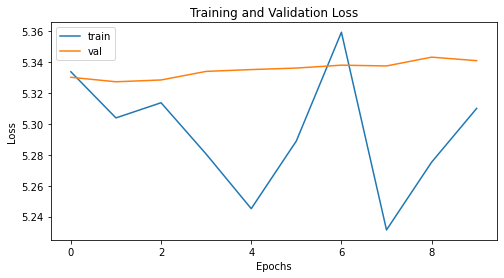

epoch 1, loss: 5.311559, validation loss: 5.315868
epoch 5, loss: 5.345280, validation loss: 5.336115
epoch 10, loss: 5.350576, validation loss: 5.340313


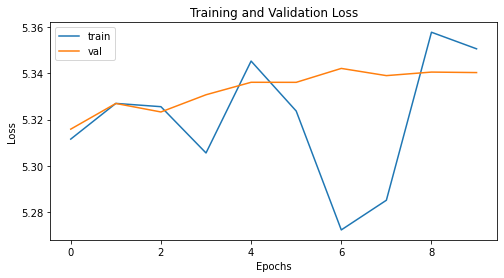

epoch 1, loss: 5.314275, validation loss: 5.303202
epoch 5, loss: 5.310997, validation loss: 5.332127
epoch 10, loss: 5.369124, validation loss: 5.341137


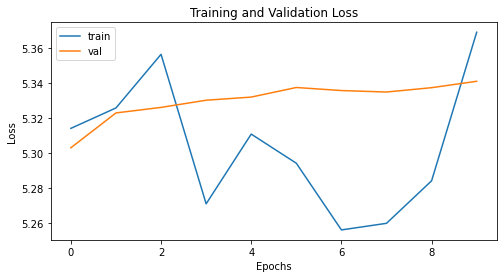

In [ ]:
# first search for best architecure type:

for model in [vgg_11, vgg_13, vgg_16]:
  training_loop(model, 11, loss_birds, loader_train, loader_val)


So me might have a problem here.

None of the models is really able to bring down the loss siginficaltly, the val loss is even increasing. A fellow student told me he observed the same phenomenon with his training.

I guess trying to train a classifier from scratch with 200 classes and just ~6000 train images is just too much to ask. We have less than 30 images per class, very hard to train.
Also training takes a lot of time, so I am trying to find a better learn-rate in the next step, but other than that I am not optimizing further.

The best out of three bad choices seems to be to use vgg-16. The val-loss seems to be the lowest here, although differences are very small.

epoch 1, loss: 5.470410, validation loss: 5.458419
epoch 5, loss: 5.846878, validation loss: 5.523977


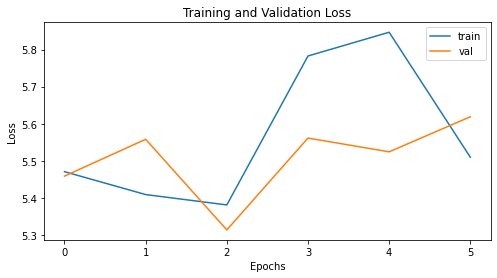

epoch 1, loss: 5.354855, validation loss: 5.416934
epoch 5, loss: 5.274369, validation loss: 5.323966


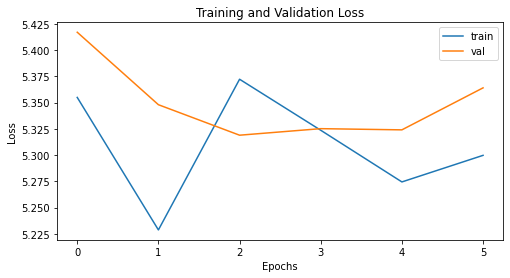

epoch 1, loss: 5.290491, validation loss: 5.354352
epoch 5, loss: 5.304526, validation loss: 5.348393


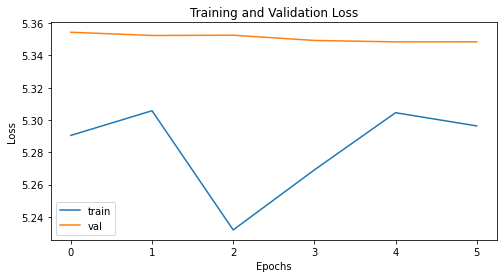

In [ ]:
# trying to optimize learnrate on a log-scale:

for learnrate in [0.1,0.01, 0.001]:
  training_loop(vgg_16, 7, loss_birds, loader_train, loader_val, learnrate)

learning rate 0.001 seems to be the best, it actually got the validation loss down by a little bit.


###6.
Adding normalisation layers can reduce overfitting and improve network training. On the best performing architecture from step 5, add normalisation layers after conv layers and linear layers but before non-linearities using `nn.BatchNorm2d` and `nn.BatchNorm1d` respectively. Select the hyper-parameters (number of epochs, learning rate) again that maximise the performance on the validation dataset. Do you observe any improvements from your experiments in Step 5?

In [ ]:
# for this I am jsut going to alter our vgg_block function a little bit by
# adding Batchnorm2d after each conv layer (but before activation),
# and batchnorm1d after each linear layer.


def vgg_block_with_batchnorm(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):   # if more convolution after another loop over number og layers
        layers.append(
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(num_features =out_channels)) # number_features = out_channels,
        # meaning in first iteration 3 rgb channels,
        # then the number of feature_maps that go out of the conv layer. (3,64, 128,256...and so on)
        layers.append(nn.ReLU()) # after each convulution, one relu activation
        in_channels = out_channels
    # max-ppoling after convolution block with 1 or more convolutions
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) 
    return nn.Sequential(*layers)


def vgg_block_with_bantchnorm(conv_setup):
    conv_blks = []
    in_channels = 3 # important to change this to 3, we have rgb-images in our dataset, so 3 channels
    # The convolutional part
    for (num_convs, out_channels) in conv_setup:
        conv_blks.append(vgg_block_with_batchnorm(num_convs, 
                                   in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), # 7x7 is the shape of the last feature map of the last conv-layer
        nn.BatchNorm1d(4096),
        nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(), nn.Dropout(0.4),
        nn.Linear(1000, 200))  # putting a additional linear layer with 200 outputs at the end,
        # to get a prob for each class, softmax will be included in the crossentropy-loss,
        # I am not specifically adding a softmax-layer for that.

vgg_16_batchnorm = vgg_block_with_bantchnorm(vgg_16_setup).to('cuda')

X = torch.rand(size=(8, 3, 224, 224)).to('cuda')
for layer in vgg_16_batchnorm:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([8, 64, 112, 112])
Sequential output shape:	 torch.Size([8, 128, 56, 56])
Sequential output shape:	 torch.Size([8, 256, 28, 28])
Sequential output shape:	 torch.Size([8, 512, 14, 14])
Sequential output shape:	 torch.Size([8, 512, 7, 7])
Flatten output shape:	 torch.Size([8, 25088])
Linear output shape:	 torch.Size([8, 4096])
BatchNorm1d output shape:	 torch.Size([8, 4096])
ReLU output shape:	 torch.Size([8, 4096])
Dropout output shape:	 torch.Size([8, 4096])
Linear output shape:	 torch.Size([8, 4096])
BatchNorm1d output shape:	 torch.Size([8, 4096])
ReLU output shape:	 torch.Size([8, 4096])
Dropout output shape:	 torch.Size([8, 4096])
Linear output shape:	 torch.Size([8, 1000])
BatchNorm1d output shape:	 torch.Size([8, 1000])
ReLU output shape:	 torch.Size([8, 1000])
Dropout output shape:	 torch.Size([8, 1000])
Linear output shape:	 torch.Size([8, 200])


epoch 1, loss: 5.160666, validation loss: 8.689062
epoch 5, loss: 5.266471, validation loss: 6.373432
epoch 10, loss: 5.342365, validation loss: 5.331379


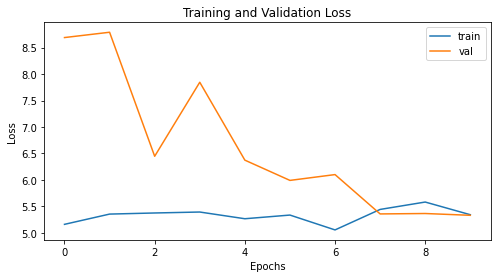

epoch 1, loss: 5.453234, validation loss: 5.330467
epoch 5, loss: 5.332484, validation loss: 8.559435
epoch 10, loss: 5.329289, validation loss: 7.586477


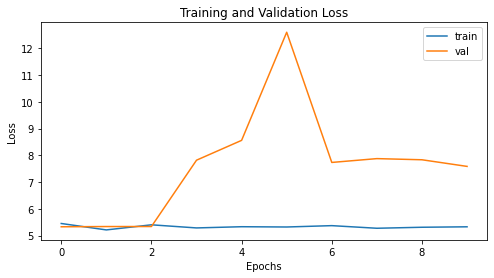

epoch 1, loss: 5.263883, validation loss: 13.586871
epoch 5, loss: 5.258559, validation loss: 7.686248
epoch 10, loss: 5.219229, validation loss: 9.235556


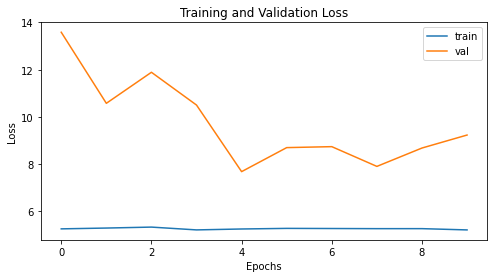

In [ ]:
for learnrate in [0.01,0.005,0.001]:
  training_loop(vgg_16_batchnorm, 11, loss_birds, loader_train, loader_val, learnrate)

That did not help.
Train loss is staying basically the same as without batchnorm, but the
validation loss goes hellwire sometimes.
Interestingly enough now the bigger learnrate 0.01 seems to be the best.

Since all my approaches didn't lead far, I am doing a kind of sanity check if there is something wrong with my net.
I am trying to  overfit hard on a subset of the data and see if that bring the train loss down.

In [ ]:
# First, resetting the weights of vgg_16_batchnorm:

for layer in vgg_16_batchnorm.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# creating a subset of the train_data (2%) to overfit

subset_size = int(0.02*len(birds_train))
rest = len(birds_train)-subset_size

birds_subset,_ = random_split(birds_train, [subset_size, rest])

len(birds_subset)
# just 107 pictures now.
         

107

epoch 1, loss: 5.515274, validation loss: 7.422851
epoch 5, loss: 4.466870, validation loss: 6.230570
epoch 10, loss: 3.419810, validation loss: 6.911506
epoch 15, loss: 3.360839, validation loss: 7.033689
epoch 20, loss: 3.254456, validation loss: 7.599262
epoch 25, loss: 3.006079, validation loss: 7.694987
epoch 30, loss: 3.305135, validation loss: 7.466559
epoch 35, loss: 2.778789, validation loss: 7.470605
epoch 40, loss: 3.610821, validation loss: 7.976844
epoch 45, loss: 3.261765, validation loss: 8.357656
epoch 50, loss: 2.895153, validation loss: 8.519816
epoch 55, loss: 2.871845, validation loss: 8.119798
epoch 60, loss: 2.513621, validation loss: 8.664918
epoch 65, loss: 3.105458, validation loss: 9.447480
epoch 70, loss: 2.894396, validation loss: 8.828874
epoch 75, loss: 1.447600, validation loss: 8.933227
epoch 80, loss: 1.861580, validation loss: 9.593314
epoch 85, loss: 1.140043, validation loss: 10.016808
epoch 90, loss: 2.535612, validation loss: 9.673409
epoch 95, los

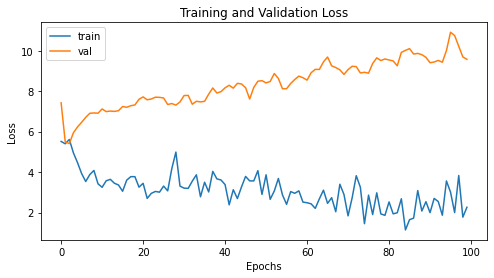

In [ ]:
transforms_subset = transforms.Compose([
                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
                    transforms.RandomResizedCrop(224)])

birds_subset = Dataset_transform(birds_subset, transform=transforms_subset)                                

loader_subset =  torch.utils.data.DataLoader(birds_subset, batch_size=16,shuffle=False)

training_loop(vgg_16_batchnorm, 101, loss_birds, loader_subset, loader_val, learnrate=0.001)

I am just caring for the train-loss here and we see it actually go down sigificantly.

At the lowest around 0.9, which is good, so our net seems to be allright, it is just very hard to train 200 classes with very similar birds and only 6000 examples.



### 7.
Evaluate and report the performance of the best performing model from step 5/6 on the test set.  Randomly select 10 examples from the test set. Visualise the 10 images along with the ground truth category and predicted category with your best model.


In [ ]:
# I dont really have a clear best model, since all the val_loss values for
# different models are around 5.3, I am just choosing vgg_16 without batchnorm and
# a learnrate of 0.001.
# Reseting vgg_16 and train for last time (the last training on vgg_16 was with a
# different learn-rate)


vgg_16 = vgg(vgg_16_setup).to('cuda')

training_loop(vgg_16, 3, loss_birds, loader_train, loader_val, 0.001, plot=False)


correct = 0
total = 0

vgg_16.eval()
with torch.no_grad():
    for images, labels in loader_test:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = vgg_16(images)
        _, predicted = torch.max(outputs, dim=1) # alternative: predicted = torch.argmax(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
    print("Accuracy over whole testset: {}".format(correct / total))

epoch 1, loss: 5.293121, validation loss: 5.302325
Accuracy over whole testset: 0.0051777701070072485


So by chance we had a theoretical accuracy of 0.05. (1/200 classes)

My accuracy is 0.00517, which is only very slightly better and definitely not statistically significant better that 0.05. My guess is that by pure luck the net is a little bit better.

This shows that training from scratch with not a lot of data and a lot of classes is not a good idea.
We wouldnt be worse by randomly guessing.

I hope the grading won't be based too much on the accuracy here.
With my limited resouces ( I can't train for tens of hours) I couln't make any progress here.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


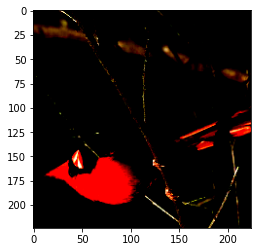

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class of the above image: index : 16, name: 017.Cardinal
Prediction class of my net: 176


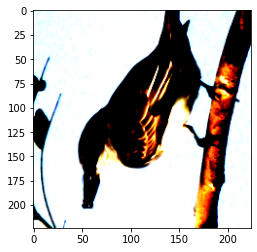

Class of the above image: index : 77, name: 078.Gray_Kingbird
Prediction class of my net: 176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


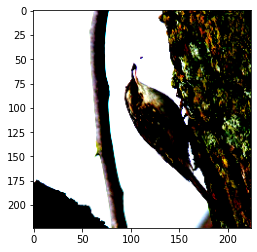

Class of the above image: index : 27, name: 028.Brown_Creeper


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction class of my net: 176


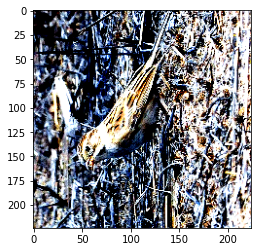

Class of the above image: index : 116, name: 117.Clay_colored_Sparrow


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction class of my net: 176


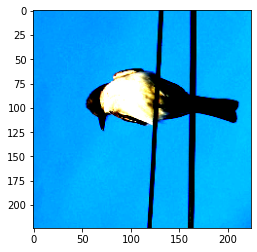

Class of the above image: index : 77, name: 078.Gray_Kingbird
Prediction class of my net: 176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


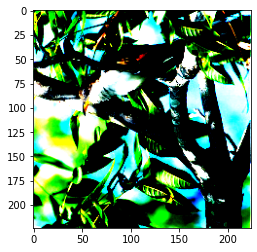

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class of the above image: index : 32, name: 033.Yellow_billed_Cuckoo
Prediction class of my net: 176


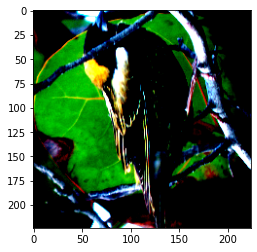

Class of the above image: index : 12, name: 013.Bobolink


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction class of my net: 176


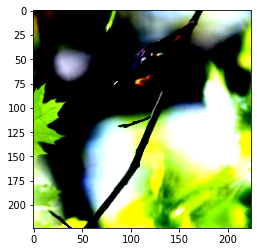

Class of the above image: index : 108, name: 109.American_Redstart


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction class of my net: 176


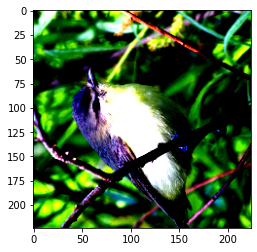

Class of the above image: index : 152, name: 153.Philadelphia_Vireo
Prediction class of my net: 176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


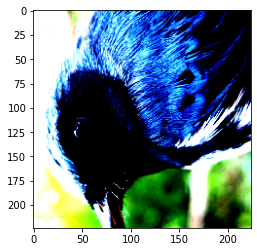

Class of the above image: index : 159, name: 160.Black_throated_Blue_Warbler
Prediction class of my net: 176


In [ ]:
import random
import time
random.seed(123)
# showing ten examples:

# first draw 10 random indices from test_data:
indices = random.sample(range(len(birds_test)), 10)



for index in indices:
  plt.imshow(birds_test[index][0].permute(2, 1, 0))
  plt.show()
  print(f"Class of the above image: index : {birds_test[index][1]}, name: {birds_test_raw.classes[birds_test[index][1]]}")
  image = birds_test[index][0].unsqueeze(0).to('cuda') # adding one dimension to image-tensor and moving it to cuda
  _, predicted = torch.max(vgg_16(image), dim=1) # get predicition for that picture
  print(f"Prediction class of my net: {predicted[0]}")



The vgg_16 from scratch didnt learn anything ,
it just spits out class 176, no matter what the input is.


# Part B - Transfer Learning 
In the second part, you will employ transfer learning with a ResNet-18 network pertained on ImageNet dataset for classifying 200 bird species in Caltech-UCSD Birds 200-2011 image dataset. Review the section on Transfer Learning from lecture notes by Andrej Karpathy. 

### 1. ResNet-18 as fixed feature extractor 

Take the `ResNet-18` pretrained on ImageNet. The last layer’s outputs are the `1000` class scores for ImageNet dataset. Therefore, we can treat the rest of the `ResNet-18` as a fixed feature extractor for the Caltech-UCSD Birds 200-2011 image dataset. You should replace the last fully connected layer in ResNet-18 with a new one with random weights and train only the parameters of this new layer. Next, you should search for the hyper-parameters (number of epochs, learning rate) that maximise the performance on the validation dataset.


In [ ]:

model_ft = models.resnet18(pretrained=True)


for param in model_ft.parameters():
  param.requires_grad = False

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 200) # 200 classes, so the linear layer needs 200 outputs

model_ft = model_ft.cuda()



In [ ]:
# before training, I am changing my training_loop slightly, now I pass the optimizer
# as an argument and dont define it inside the function

import matplotlib.pyplot as plt

def training_loop_pre(model, epochs, loss_function, optimizer, train_loader, val_loader, plot=True, reset=False):
    training_loss_values = [] # empty list we store the loss-value in after each epoch
    val_loss_values = []
    for epoch in range(1,epochs):
      model.train()
      for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        out = model(images)
        loss = loss_function(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      loss = loss_function(out, labels)
      training_loss_values.append(loss) # add to list which will be plotted
      model.eval() # now in evaluation mode, important for dropout
      with torch.no_grad():  # disable gradient evaluation
        for images, labels in val_loader:
          images, labels = images.to('cuda'), labels.to('cuda')
          out = model(images)  
        val_loss = loss_function(out, labels)
        val_loss_values.append(val_loss) #add val_loss to list
      if epoch == 1 or epoch % 5 == 0:  
          print(f'epoch {epoch}, loss: {loss:f}, validation loss: {val_loss:f}')
    # reseting weight after training:
    if reset:   
      for layer in model.children():
          if hasattr(layer, 'reset_parameters'):
              layer.reset_parameters()      
    if plot:       
      plt.figure(figsize=(8,4))
      plt.title(f'Training and Validation Loss')
      plt.plot(training_loss_values,label="train")
      plt.plot(val_loss_values,label="val")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()
      


epoch 1, loss: 42.492252, validation loss: 53.136127
epoch 5, loss: 5.176248, validation loss: 39.184631


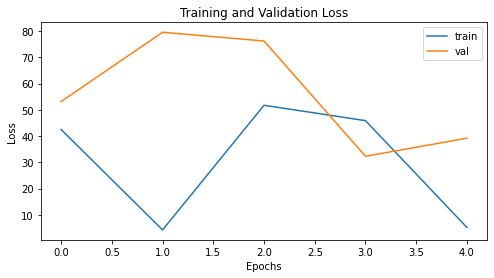

epoch 1, loss: 6.527194, validation loss: 5.482266
epoch 5, loss: 4.895912, validation loss: 4.927004


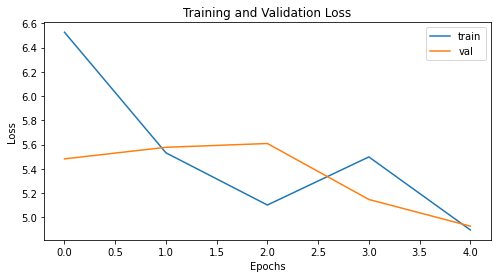

epoch 1, loss: 5.551472, validation loss: 5.315051
epoch 5, loss: 4.669755, validation loss: 5.685413


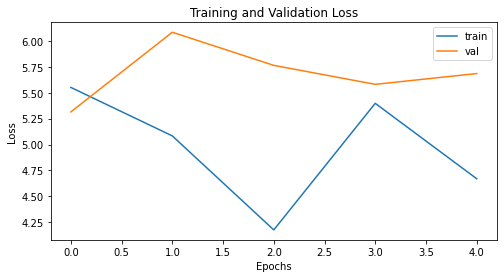

In [ ]:
# search for good learnrate:

for learnrate in [0.01, 0.0005, 0.001]:
  optimizer_ft = torch.optim.Adam(model_ft.fc.parameters(), lr=learnrate)
  training_loop_pre(model_ft, 6,loss_birds,optimizer_ft,loader_train, loader_val, reset=True)

I think the second graph looks the best, maybe indicating if we learn further loss will further decrease. 

I am trying this learnrate 0.0005 with more epochs:

epoch 1, loss: 5.799762, validation loss: 4.938328
epoch 5, loss: 4.568588, validation loss: 5.563303
epoch 10, loss: 3.959008, validation loss: 4.695862
epoch 15, loss: 6.693365, validation loss: 5.012597
epoch 20, loss: 5.282727, validation loss: 5.397170


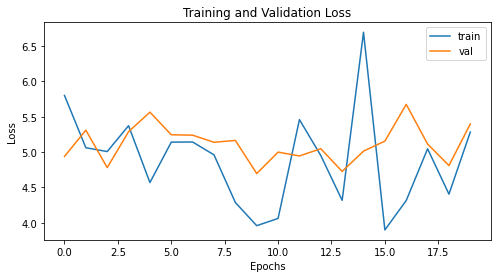

In [ ]:
optimizer_ft = torch.optim.Adam(model_ft.fc.parameters(), lr=0.0005)

# and I am trying a bigger (twice) batchsize. not 16, previously 8.
# going to use batchsite 16 from now on and also in the final model.
loader_train = torch.utils.data.DataLoader(birds_train, batch_size=16,shuffle=True)
loader_val = torch.utils.data.DataLoader(birds_val, batch_size=16,shuffle=False)

training_loop_pre(model_ft, 21,loss_birds,optimizer_ft,loader_train, loader_val, reset=False)


after eigt epochs the val loss and train loss look the best.

### 2. Fine-tuning the ResNet-18

Another way to exploit transfer learning is to not only replace the last layer, but to also fine-tune the weights of the pretrained network. Therefore, in this setting, you should replace the last fully connected layer in `ResNet-18` with a new one with random weights and train the parameters of this new layer as well as the pretrained part. Next, you should again for this setting, search for the hyper-parameters (number of epochs, learning rate) that maximise the performance on the validation dataset.

In [ ]:
resnet_finetune = models.resnet18(pretrained=True)

# now not setting requires_grad = False for pretrained net.

# adding last layer:

num_ftrs = resnet_finetune.fc.in_features

resnet_finetune.fc = nn.Linear(num_ftrs, 200) # 200 classes, so the linear layer needs 200 outputs

resnet_finetune = resnet_finetune.cuda()


epoch 1, loss: 5.363055, validation loss: 5.322900
epoch 5, loss: 5.426698, validation loss: 4.754657


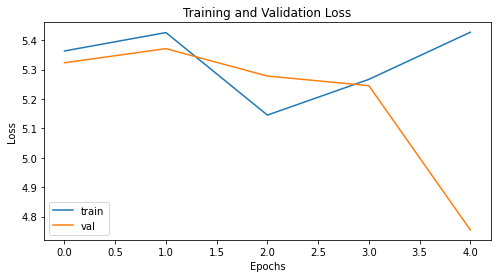

epoch 1, loss: 5.185768, validation loss: 6.134497
epoch 5, loss: 5.108057, validation loss: 5.095667


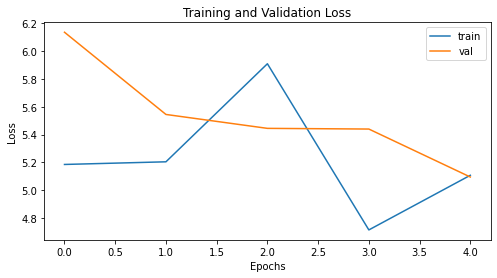

epoch 1, loss: 5.065436, validation loss: 5.479311
epoch 5, loss: 4.960464, validation loss: 4.944210


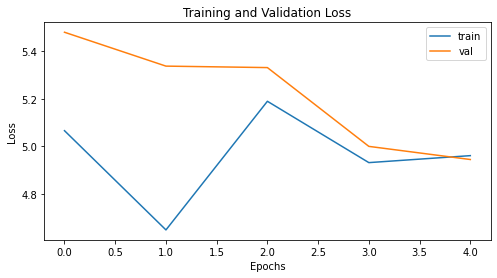

In [ ]:
# now pass all model parameters to optimizer:

for learnrate in [0.01,0.005, 0.001]:
  optimizer_finetune = torch.optim.Adam(resnet_finetune.parameters(), lr=learnrate)
  training_loop_pre(resnet_finetune, 6, loss_birds, optimizer_finetune, loader_train, loader_val, reset=True)

###3. Other pertained networks

Repeat the above above two steps for another pertained network: `mobilenet_v3_small`. Provide comparison of the inference time and training time per epoch for fine tuning `ResNet-18` and `MobileNetV3`. Optionally read about [MobileNets](https://arxiv.org/pdf/1905.02244.pdf).

In [ ]:
mobilenet = models.mobilenet_v3_small(pretrained=True)


for param in mobilenet.parameters():
  param.requires_grad = False

# looking how the last part is called and how the layers look like:
mobilenet.classifier


Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [ ]:
# from the mobilenet.classifier call, which shows the fc layers,
# we can see see that without adjustments we have 100 outputfeatrues in the
# last fc layer 3.
# changing that:

mobilenet.classifier[3] = nn.Linear(in_features=1024, out_features=200)

mobilenet.classifier

mobilenet = mobilenet.cuda()

epoch 1, loss: 4.729008, validation loss: 7.047037
epoch 5, loss: 1.523228, validation loss: 9.839229


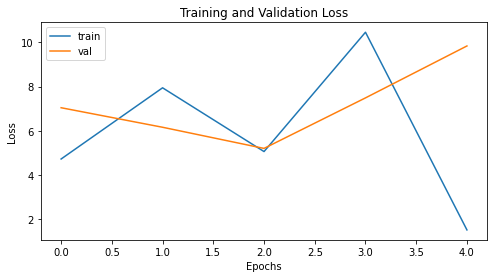

epoch 1, loss: 4.394794, validation loss: 3.706198
epoch 5, loss: 4.909540, validation loss: 4.934120


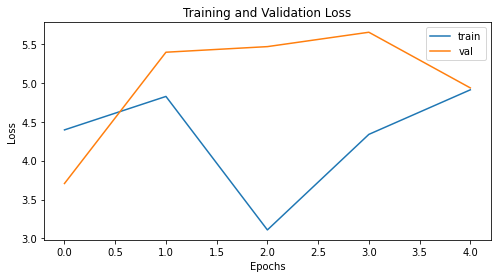

epoch 1, loss: 5.003406, validation loss: 3.889649
epoch 5, loss: 3.885466, validation loss: 2.965779


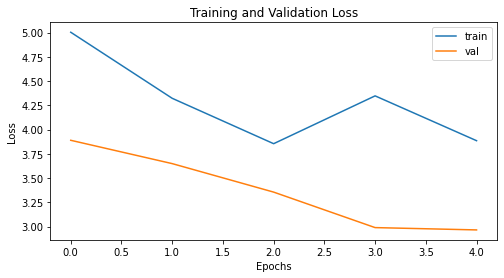

In [ ]:
# starting to optimize the mobilenet:



# learmrate 0.01

optimizer_mobile = torch.optim.Adam(mobilenet.classifier[3].parameters(), lr=0.01)
training_loop_pre(mobilenet, 6, loss_birds, optimizer_mobile, loader_train, loader_val, reset=True)

# learnrate 0.005
mobilenet = models.mobilenet_v3_small(pretrained=True)
for param in mobilenet.parameters():
  param.requires_grad = False

mobilenet.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet = mobilenet.cuda()

optimizer_mobile = torch.optim.Adam(mobilenet.classifier[3].parameters(), lr=0.005)
training_loop_pre(mobilenet, 6, loss_birds, optimizer_mobile, loader_train, loader_val, reset=True)

# learnrate 0.001
mobilenet = models.mobilenet_v3_small(pretrained=True)
for param in mobilenet.parameters():
  param.requires_grad = False

mobilenet.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet = mobilenet.cuda()

optimizer_mobile = torch.optim.Adam(mobilenet.classifier[3].parameters(), lr=0.001)
training_loop_pre(mobilenet, 6, loss_birds, optimizer_mobile, loader_train, loader_val, reset=True)



epoch 1, loss: 4.955078, validation loss: 4.825484
epoch 5, loss: 6.168831, validation loss: 4.694719


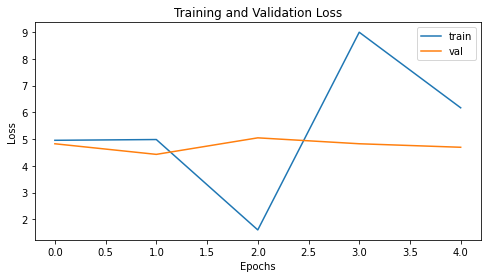

epoch 1, loss: 4.436944, validation loss: 4.529640
epoch 5, loss: 5.419514, validation loss: 4.818898


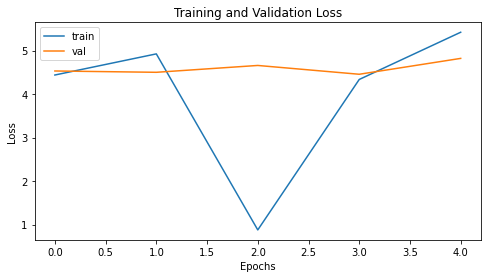

epoch 1, loss: 5.342196, validation loss: 4.622705
epoch 5, loss: 3.232591, validation loss: 4.736924


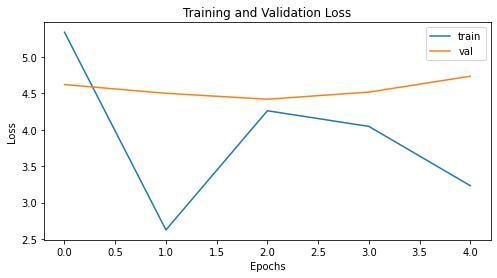

In [ ]:
# trying the sgd optimizer

 # learnrate 0.1
mobilenet = models.mobilenet_v3_small(pretrained=True)
for param in mobilenet.parameters():
  param.requires_grad = False

mobilenet.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet = mobilenet.cuda()

optimizer_mobile = torch.optim.SGD(mobilenet.classifier[3].parameters(), lr=0.001)
training_loop_pre(mobilenet, 6, loss_birds, optimizer_mobile, loader_train, loader_val, reset=True)

# learnrate 0.01
mobilenet = models.mobilenet_v3_small(pretrained=True)
for param in mobilenet.parameters():
  param.requires_grad = False

mobilenet.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet = mobilenet.cuda()

optimizer_mobile = torch.optim.SGD(mobilenet.classifier[3].parameters(), lr=0.01)
training_loop_pre(mobilenet, 6, loss_birds, optimizer_mobile, loader_train, loader_val, reset=True)

# learnrate 0.001
mobilenet = models.mobilenet_v3_small(pretrained=True)
for param in mobilenet.parameters():
  param.requires_grad = False

mobilenet.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet = mobilenet.cuda()

optimizer_mobile = torch.optim.SGD(mobilenet.classifier[3].parameters(), lr=0.001)
training_loop_pre(mobilenet, 6, loss_birds, optimizer_mobile, loader_train, loader_val, reset=True)

The sgd optimizer seems to work way better here that adam.

Val_loss is for the first time around ~4.5.

Going forward just using the sgd-optimizer.
Maybe a mistake to fokus on adam earlier.




In [ ]:
## mobilenet updating all params

mobilenet_finetune = models.mobilenet_v3_small(pretrained=True)
mobilenet_finetune.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet_finetune = mobilenet_finetune.cuda()



epoch 1, loss: 5.769014, validation loss: 4.592882
epoch 5, loss: 1.015700, validation loss: 2.502634


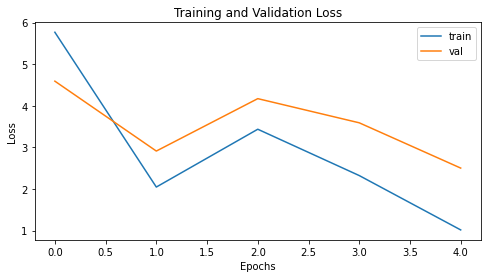

epoch 1, loss: 5.027313, validation loss: 5.140524
epoch 5, loss: 3.411016, validation loss: 2.966367


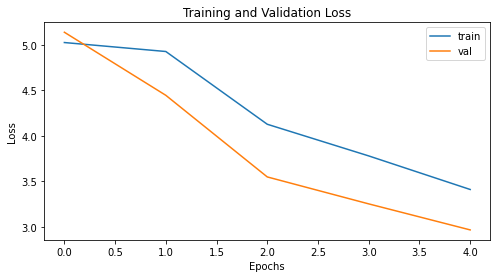

epoch 1, loss: 5.409054, validation loss: 5.324595
epoch 5, loss: 5.368184, validation loss: 5.214931


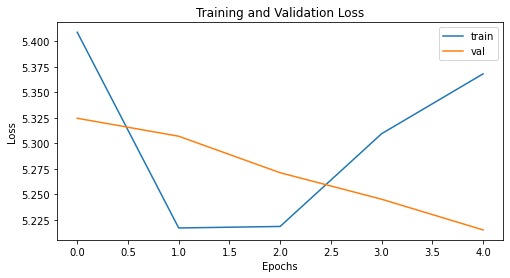

In [ ]:
# comparing different learnrates:

# learnrate 0.1
optimizer_mobile_ft = torch.optim.SGD(mobilenet_finetune.parameters(), lr=0.1)
training_loop_pre(mobilenet_finetune, 6, loss_birds, optimizer_mobile_ft, loader_train, loader_val, reset=True)

# learnrate 0.01
mobilenet_finetune = models.mobilenet_v3_small(pretrained=True)
mobilenet_finetune.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet_finetune = mobilenet_finetune.cuda()
optimizer_mobile_ft = torch.optim.SGD(mobilenet_finetune.parameters(), lr=0.01)
training_loop_pre(mobilenet_finetune, 6, loss_birds, optimizer_mobile_ft, loader_train, loader_val, reset=True)

# learnrate 0.001
mobilenet_finetune = models.mobilenet_v3_small(pretrained=True)
mobilenet_finetune.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet_finetune = mobilenet_finetune.cuda()
optimizer_mobile_ft = torch.optim.SGD(mobilenet_finetune.parameters(), lr=0.001)
training_loop_pre(mobilenet_finetune, 6, loss_birds, optimizer_mobile_ft, loader_train, loader_val, reset=True)

These values finally look really good and like there is something happening.

Learnrate 0f 0.01 seems to be the best.



In [ ]:
import time

##### comparing times:

# time alex net one epoch of training
# comparing times when just the last linear layer gets trained.

# defining net again:
resnet_ft = models.resnet18(pretrained=True)

for param in resnet_ft.parameters():
  param.requires_grad = False

num_ftrs = resnet_ft.fc.in_features

resnet_ft.fc = nn.Linear(num_ftrs, 200) # 200 classes, so the linear layer needs 200 outputs
resnet_ft = resnet_ft.cuda()

optimizer = torch.optim.SGD(resnet_ft.fc.parameters(), lr=0.01)

# timing one epoch of training:
start_time = time.time()

training_loop_pre(resnet_ft, 2, loss_birds, optimizer, loader_train, loader_val,plot=False,reset=False)

print("--- %s seconds ---" % (time.time() - start_time))



epoch 1, loss: 4.879278, validation loss: 5.199824
--- 48.9926061630249 seconds ---


In [ ]:
## time mobile net one epoch of training

mobilenet = models.mobilenet_v3_small(pretrained=True)

for param in mobilenet.parameters():
  param.requires_grad = False

mobilenet.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet = mobilenet.cuda()  

# same optimizer in both comparing models:
optimizer = torch.optim.SGD(mobilenet.classifier[3].parameters(), lr=0.01)

# timing one epoch of training:
start_time = time.time()

training_loop_pre(mobilenet, 2, loss_birds, optimizer, loader_train, loader_val,plot=False,reset=False)

print("--- %s seconds ---" % (time.time() - start_time))



epoch 1, loss: 4.952179, validation loss: 5.227410
--- 50.475502014160156 seconds ---


In training. both nets seem to be comparable timewise.
Resnet takes 49 seconds for one epoch, mobilenet_small 50.5 seconds.


In [ ]:
# comparing inference time
# (which I understand as time it takes to get an output from an input):

# to test this, I am passing 20 random indices (one at a time) from the testset
# and see how long it takes for the nets to make predictions:
# (similar to the final evaluation, where we display 10 random images + the predictions)

random.seed(99)
indices = random.sample(range(len(birds_test)), 20)

# first resnet:
# to exclude random stuff or the gpu heating up, I do this 10 times
for i in range(10):
  start_time = time.time()
  for index in indices:
    image = birds_test[index][0].unsqueeze(0).to('cuda') # adding one dimension to image-tensor and moving it to cuda
    _, predicted = torch.max(resnet_ft(image), dim=1)

  print("--- %s seconds ---" % (time.time() - start_time))


--- 0.22249722480773926 seconds ---
--- 0.21121501922607422 seconds ---
--- 0.21436429023742676 seconds ---
--- 0.21648406982421875 seconds ---
--- 0.21046781539916992 seconds ---
--- 0.22807574272155762 seconds ---
--- 0.21036386489868164 seconds ---
--- 0.21652555465698242 seconds ---
--- 0.21064019203186035 seconds ---
--- 0.21921205520629883 seconds ---


It always takes 21/22 seconds, average roughly being 21.8 seconds.

In [ ]:
for i in range(10):
  start_time = time.time()
  for index in indices:
    image = birds_test[index][0].unsqueeze(0).to('cuda') # adding one dimension to image-tensor and moving it to cuda
    _, predicted = torch.max(mobilenet(image), dim=1)

  print("--- %s seconds ---" % (time.time() - start_time))


--- 0.2665519714355469 seconds ---
--- 0.26734161376953125 seconds ---
--- 0.26882505416870117 seconds ---
--- 0.26627206802368164 seconds ---
--- 0.2642996311187744 seconds ---
--- 0.2871546745300293 seconds ---
--- 0.2615182399749756 seconds ---
--- 0.26277589797973633 seconds ---
--- 0.27140092849731445 seconds ---
--- 0.26927638053894043 seconds ---


The mobilenet actually has a longer inference time of 0.26/0.27 seconds.

This was not really what I expected. My guess is that this is because I am using/testing this  on a gpu.

Mobilenet seems to be optimized for smartphone cpu's (hence the name),
so my guess is on a cpu it will be way faster than resnet.
It uses techniques like model compression, huffmann coding and pruning to get a faster inference times on cpu.

I dont want to test this on a cpu right now, since I had change my runtime and re-load everything on a cpu, but this is what I would expect.


### 4. 
Evaluate and report the performance of the best performing model from Step 1/2/3 on the test set.  Randomly select 10 examples from the test set. Visualise the 10 images along with the ground truth category and predicted category with your best model.

In [ ]:
# to be honest I think my reset_parameter is not really working perfectly,
# so I am defining mobilenet again before the final training.
# This way I am making sure there is nothing wrong with the initial weights.

mobilenet_finetune = models.mobilenet_v3_small(pretrained=True)
mobilenet_finetune.classifier[3] = nn.Linear(in_features=1024, out_features=200)
mobilenet_finetune = mobilenet_finetune.cuda()

epoch 1, loss: 5.216066, validation loss: 5.141550
epoch 5, loss: 4.790934, validation loss: 4.584098
epoch 10, loss: 5.207295, validation loss: 3.498578
epoch 15, loss: 3.499387, validation loss: 2.465440
epoch 20, loss: 3.429763, validation loss: 1.831557
epoch 25, loss: 3.641368, validation loss: 1.543419
epoch 30, loss: 1.971806, validation loss: 1.485902


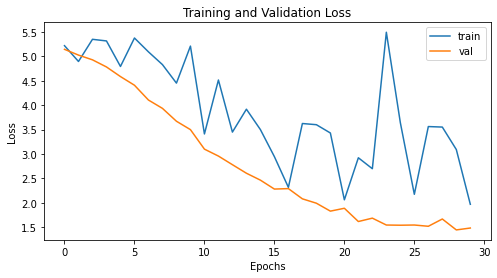

In [ ]:
# train the best model again:
# I think the mobile_net, which allowd all weights to change during training,
# did by far the best for me.
# So choosing this with a sgd-optimizer and a learnrate of 0.003.


optimizer_mobile_ft = torch.optim.SGD(mobilenet_finetune.parameters(), lr=0.003)

# last training:
training_loop_pre(mobilenet_finetune, 31, loss_birds, optimizer_mobile_ft, loader_train, loader_val, reset=False)



In [ ]:
# looks like the val_loss reaches a plateu after ~ 30 epochs, so I am
# stopping there.

# get accuracy over whole testset:
correct = 0
total = 0

mobilenet_finetune.eval()
with torch.no_grad():
    for images, labels in loader_test:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = mobilenet_finetune(images)
        _, predicted = torch.max(outputs, dim=1) # alternative: predicted = torch.argmax(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
    print("Accuracy over whole testset: {}".format(correct / total))

# excellent accuracy of 61 percent.
# Considering there are 200 classes this is really good.  

Accuracy over whole testset: 0.6225405591991715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


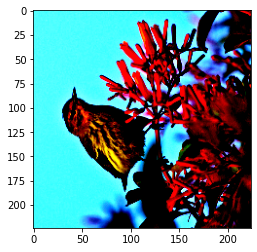

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class of the above image: index : 162, name: 163.Cape_May_Warbler
Prediction class of my net: 173


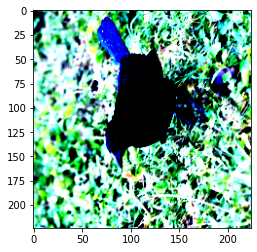

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class of the above image: index : 25, name: 026.Bronzed_Cowbird
Prediction class of my net: 25


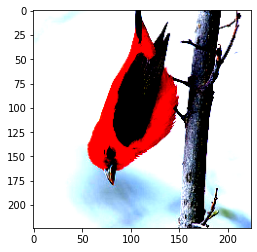

Class of the above image: index : 138, name: 139.Scarlet_Tanager


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction class of my net: 138


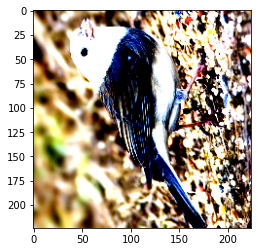

Class of the above image: index : 75, name: 076.Dark_eyed_Junco


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction class of my net: 75


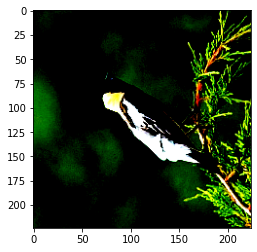

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class of the above image: index : 12, name: 013.Bobolink
Prediction class of my net: 12


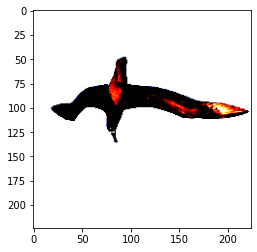

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class of the above image: index : 0, name: 001.Black_footed_Albatross
Prediction class of my net: 43


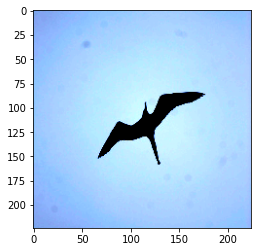

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class of the above image: index : 43, name: 044.Frigatebird
Prediction class of my net: 2


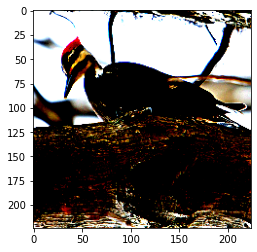

Class of the above image: index : 187, name: 188.Pileated_Woodpecker


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction class of my net: 187


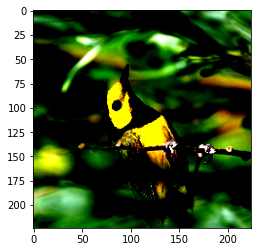

Class of the above image: index : 166, name: 167.Hooded_Warbler


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction class of my net: 166


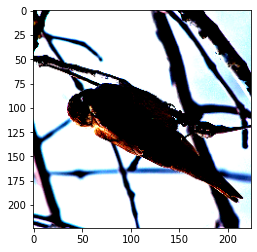

Class of the above image: index : 134, name: 135.Bank_Swallow
Prediction class of my net: 101


In [ ]:
random.seed(6)

indices = random.sample(range(len(birds_test)), 10)


for index in indices:
  plt.imshow(birds_test[index][0].permute(2, 1, 0))
  plt.show()
  print(f"Class of the above image: index : {birds_test[index][1]}, name: {birds_test_raw.classes[birds_test[index][1]]}")
  image = birds_test[index][0].unsqueeze(0).to('cuda') # adding one dimension to image-tensor and moving it to cuda
  _, predicted = torch.max(mobilenet_finetune(image), dim=1) # get predicition for that picture
  print(f"Prediction class of my net: {predicted[0]}")

With these 10 random pictures and classes, my net gets 6/10 right, which is decent. 

I am happy with that result, showing how powerful transfer learning can be.
Over all testexamples (~6000) I get an accuracy of 62.25.
In my opinion the test-set is way too big, it has the same amount of pictures as the train examples. 

You could think about using some of the test examples for training, since there we only have ~ 30 pictures per class on average.
50% training data , 50% test is not usual.

You can of course do it ,if you want really accurate test-results, but in this case we're lacking training examples at the same time.

Overall comparing training from scratch and pre-trained shows how important pretrained models and transfer learning is and
how well it can work.

Basically the explanation why transfer learning works is that if you train those models on huge datasets with million of examples like ImageNet, these datasets can effectively act as a generic model of the visual world.

And if youre good on that generic model, you can easily pick up stuff about other classes and new data, that is build on that model of the world around us.

-------------------------------------------------


There are other techniques to improve your model besides the ones suggested in part A and B. Feel free to try other ideas to improve your model. Keep in mind the computational resource constraints on Google Colab and setup your experiments judiciously.  Starting with the assignment early on is also a good strategy in order to maximise GPU time.

Please provide a short analysis of the results of your experiments in the notebook using text boxes. This assignment is worth 200 points and will be graded based on the correctness of code, completeness of experiments, clarity of analysis and performance on the test dataset. 